In [1]:
from astropy.io import fits
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from PIL import Image
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os
import ipynbname
nb_path = str(ipynbname.path())
plots_dir = os.path.join(os.path.abspath(nb_path + '/../../'), 'plots/lat_long_map/')

h2_vprf = fits.open('h2_vprf.fits', ignore_missing_end=True)[0].data
h3p_vprf = fits.open('h3p_vprf.fits', ignore_missing_end=True)[0].data
h2_verr = fits.open('h2_verr.fits', ignore_missing_end=True)[0].data
h3p_verr = fits.open('h3p_verr.fits', ignore_missing_end=True)[0].data
h2_int = fits.open('h2_int_shifted.fits', ignore_missing_end=True)[0].data
h3p_int = fits.open('h3p_int_shifted.fits', ignore_missing_end=True)[0].data
ref_sun = fits.open('ref_sun.fits', ignore_missing_end=True)[0].data

h2_vprf[h2_verr > 4] = np.nan
h3p_vprf[h3p_verr > 4] = np.nan

h2_vprf[h2_vprf > 4] = np.nan
h3p_vprf[h3p_vprf > 4] = np.nan
h2_vprf[h2_vprf < -4] = np.nan
h3p_vprf[h3p_vprf < -4] = np.nan

h2_vprf[:,:20] = np.nan
h3p_vprf[:,:20] = np.nan
h2_vprf[:,280:] = np.nan
h3p_vprf[:,280:] = np.nan

h2_verr[np.isnan(h2_vprf)] = np.nan
h3p_verr[np.isnan(h3p_vprf)] = np.nan
h2_int[np.isnan(h2_vprf)] = np.nan
h3p_int[np.isnan(h3p_vprf)] = np.nan

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.degrees(np.arctan2(y, x))
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(np.radians(phi))
    y = rho * np.sin(np.radians(phi))
    return(x, y)

def nirspec_calc_lat_long(x,y,jup_pixel_radius,jup_seangle,jup_posangle,jup_cml):
    
    jup_posangle2 = (720-jup_posangle) % 360.
    
    latit = np.zeros(5)
    longit = np.zeros(5)
    
    ccc = np.zeros(5)
    ppp = np.zeros(5)
    xxx = np.zeros(5)
    yyy = np.zeros(5)
    xxx = np.zeros(5)
    
    R = jup_pixel_radius
    
    # do a lat and long for each corner of pixel
    for corner in range(5):
        if corner == 0:
            x2 = x + 0.5
            y2 = y + 0.5
        if corner == 1:
            x2 = x + 0.5
            y2 = y - 0.5
        if corner == 2:
            x2 = x - 0.5
            y2 = y - 0.5
        if corner == 3:
            x2 = x - 0.5
            y2 = y + 0.5
        if corner == 4:
            x2 = x
            y2 = y
            
        # rotate the pixels into jovian rotational coordinates
        polar = cart2pol(x2,y2)
        new_polar = jup_posangle2 + polar[1]
        rect2 = pol2cart(polar[0], new_polar)

        xx = rect2[0]

        # stretch yy to become a sphere
        flattening = 0.06487
        losflattening = flattening * (1 - np.sin(np.radians(jup_seangle)))
        eq_po_ratio = 1 - losflattening

        yy = rect2[1] / eq_po_ratio

        pp = np.sqrt(xx**2 + yy**2) # proper distance from centre

        if pp/R < 0.998 and pp >= 1e-5:
            cc = np.arcsin(pp/R) # angular distance from centre

            ccc[corner] = cc
            ppp[corner] = pp
            xxx[corner] = xx
            yyy[corner] = yy

            latit[corner] = np.arcsin((np.cos(cc) * np.sin(np.radians(jup_seangle))) + ((yy * np.sin(cc) * np.cos(np.radians(jup_seangle))) / pp))
#             longit[corner] = np.radians(jup_cml) - np.arctan((xx * np.sin(cc)) / ((pp * np.arccos(np.radians(jup_seangle)) * np.cos(cc)) - (yy * np.sin(np.radians(jup_seangle)) * np.sin(cc))))
            longit[corner] = ((np.radians(jup_cml) - np.arctan2((xx * np.sin(cc)), ((pp * np.arccos(np.radians(jup_seangle)) * np.cos(cc)) - (yy * np.sin(np.radians(jup_seangle)) * np.sin(cc))))) + (2*np.pi)) % (2*np.pi)
#         elif pp/R < 0.998 and pp < 1e-5:
#             cc = np.arcsin(pp/R) # angular distance from centre

#             ccc[corner] = cc
#             ppp[corner] = pp
#             xxx[corner] = xx
#             yyy[corner] = yy

#             latit[corner] = np.nanmean(np.arcsin((np.cos(cc) * np.sin(np.radians(jup_seangle))) + ((yy * np.sin(cc) * np.cos(np.radians(jup_seangle))) / pp)))
#             longit[corner] = ((np.radians(jup_cml) - np.arctan2((xx * np.sin(cc)), ((pp * np.arccos(np.radians(jup_seangle)) * np.cos(cc)) - (yy * np.sin(np.radians(jup_seangle)) * np.sin(cc))))) * (2*np.pi)) % (2*np.pi)
#         print(latit)
            
    """
    zzz = where(longit ne 0.,zzzcount)
    """
    
    return latit, longit

def slit_to_lat_long(x,y,jup_pixel_radius,jup_seangle,jup_posangle,jup_cml):
    
    jup_posangle2 = (720-jup_posangle) % 360.
    
    latit = np.zeros(5)
    longit = np.zeros(5)
    
    ccc = np.zeros(5)
    ppp = np.zeros(5)
    xxx = np.zeros(5)
    yyy = np.zeros(5)
    xxx = np.zeros(5)
    
    R = jup_pixel_radius
    
    # do a lat and long for each corner of pixel
    for corner in range(5):
        if corner == 0:
            x2 = x + 0.5
            y2 = y + 1.44
        if corner == 1:
            x2 = x + 0.5
            y2 = y - 1.44
        if corner == 2:
            x2 = x - 0.5
            y2 = y - 1.44
        if corner == 3:
            x2 = x - 0.5
            y2 = y + 1.44
        if corner == 4:
            x2 = x
            y2 = y
            
        # rotate the pixels into jovian rotational coordinates
        polar = cart2pol(x2,y2)
        new_polar = jup_posangle2 + polar[1]
        rect2 = pol2cart(polar[0], new_polar)

        xx = rect2[0]

        # stretch yy to become a sphere
        flattening = 0.06487
        losflattening = flattening * (1 - np.sin(np.radians(jup_seangle)))
        eq_po_ratio = 1 - losflattening

        yy = rect2[1] / eq_po_ratio

        pp = np.sqrt(xx**2 + yy**2) # proper distance from centre

        if pp/R < 0.998 and pp >= 1e-5:
            cc = np.arcsin(pp/R) # angular distance from centre

            ccc[corner] = cc
            ppp[corner] = pp
            xxx[corner] = xx
            yyy[corner] = yy

            latit[corner] = np.arcsin((np.cos(cc) * np.sin(np.radians(jup_seangle))) + ((yy * np.sin(cc) * np.cos(np.radians(jup_seangle))) / pp))
            longit[corner] = ((np.radians(jup_cml) - np.arctan2((xx * np.sin(cc)), ((pp * np.arccos(np.radians(jup_seangle)) * np.cos(cc)) - (yy * np.sin(np.radians(jup_seangle)) * np.sin(cc))))) + (2*np.pi)) % (2*np.pi)
    
    return np.degrees(latit), np.degrees(longit)


cmlsel = pd.read_csv('cml-sel.txt', sep='\s+', header=None)
jup_cml = cmlsel[3].to_numpy()

ang_diam = 40.58867
jup_pixel_radius = ang_diam/(0.1)/2

jup_seangle = -3.098
jup_posangle = 0

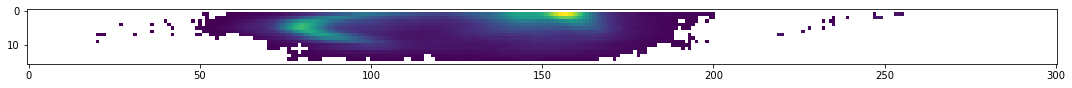

In [13]:
h3p_int1 = np.roll(h3p_int[:6], 23, axis=1)
h3p_int2 = np.roll(h3p_int[6:11], 22, axis=1)
h3p_int3 = np.roll(h3p_int[11:16], 30, axis=1)
h3p_int4 = np.roll(h3p_int[16:27], -14, axis=1)
h3p_int5 = np.roll(h3p_int[27:], -18, axis=1)
h3p_int_new = np.vstack((h3p_int1, h3p_int2, h3p_int3, h3p_int4, h3p_int5))

h3p_int2 = np.delete(h3p_int, np.s_[16:], axis=0)

fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

fig.add_subplot(313)

plt.imshow(h3p_int2)

In [14]:
h3p_int2.shape

(16, 301)

In [3]:
init_x = np.arange(150, 151, 1)
init_y = np.arange(187, 188, 1)

for k in range(len(init_x)):
    print (init_x[k])

for k in range(len(init_y)):
    print (init_y[k])

150
187


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


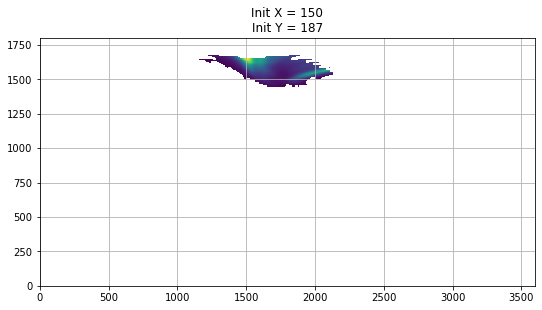

In [16]:
seangle = -3.098
r = ang_diam/(0.1)/2
posangle = 0

h3p_full = np.zeros((1801, 3601))
h3p_count = np.zeros((1801, 3601))

init_x = 150 #np.arange(150, 151, 1)
init_y = 187 #np.arange(187, 188, 1)

# for k in range(len(init_x)):

for j in range(h3p_int2.shape[0]):

    cml = jup_cml[j]

    for i in range(h3p_int2.shape[1]):
        x = i - init_x
        y = init_y - j*2

#         if j == 3 or j == 4:

        grid_y, grid_x = np.mgrid[-90:90:1801j, 0:360:3601j]

        latlong = slit_to_lat_long(x,y,r,seangle,posangle,cml)

        points = np.stack((latlong[1][0:4], latlong[0][0:4]), axis=1)

        if np.count_nonzero(points) == 8:

            values = (points[:,0]*0 + 1.)*h3p_int2[j][i]

            grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)

            h3p_full += grid_z1*1

            grid_z1[np.nonzero(grid_z1)] = 1
            h3p_count += grid_z1*1
            
h3p_div = h3p_full/h3p_count

fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

fig.add_subplot(211)
plt.imshow(h3p_div, origin='lower')
plt.grid()
plt.title('Init X = '+str(init_x)+'\nInit Y = '+str(init_y))

hdu = fits.PrimaryHDU(h3p_div)
hdu.writeto(plots_dir+'h3p_div_x'+str(init_x)+'_y'+str(init_y)+'_t.fits', overwrite=True)
    
# fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

# fig.add_subplot(311)
# plt.imshow(h3p_full/h3p_count, origin='lower')
# # plt.xlim(1000,2000)
# # plt.ylim(1500,1700)
# plt.title('Linear')

# fig.add_subplot(312)
# plt.imshow(h3p_full, origin='lower')
# # plt.xlim(1000,2000)
# # plt.ylim(1500,1700)
# plt.title('Int')

# fig.add_subplot(313)
# # plt.plot(grid_z1[1600])
# plt.imshow(h3p_count, origin='lower')
# # plt.xlim(1000,2000)
# # plt.ylim(1500,1700)
# plt.title('Count')

# hdu1 = fits.PrimaryHDU(h3p_full)
# hdu1.writeto('h3p_int_full.fits', overwrite=True)

# hdu2 = fits.PrimaryHDU(h3p_count)
# hdu2.writeto('h3p_int_count.fits', overwrite=True)

# hdu3 = fits.PrimaryHDU(h3p_full/h3p_count)
# hdu3.writeto('h3p_int_div.fits', overwrite=True)

In [3]:
# h3p_div_x130_y186 = fits.open(plots_dir+'h3p_div_x130_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x135_y186 = fits.open(plots_dir+'h3p_div_x135_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x140_y186 = fits.open(plots_dir+'h3p_div_x140_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x145_y186 = fits.open(plots_dir+'h3p_div_x145_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x150_y186 = fits.open(plots_dir+'h3p_div_x150_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x155_y186 = fits.open(plots_dir+'h3p_div_x155_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x160_y186 = fits.open(plots_dir+'h3p_div_x160_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x165_y186 = fits.open(plots_dir+'h3p_div_x165_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x170_y186 = fits.open(plots_dir+'h3p_div_x170_y186.fits', ignore_missing_end=True)[0].data
# h3p_div_x165_y181 = fits.open(plots_dir+'h3p_div_x165_y181.fits', ignore_missing_end=True)[0].data
# h3p_div_x165_y180 = fits.open(plots_dir+'h3p_div_x165_y180.fits', ignore_missing_end=True)[0].data
# h3p_div_x170_y180 = fits.open(plots_dir+'h3p_div_x170_y180.fits', ignore_missing_end=True)[0].data
# h3p_div_x170_y175 = fits.open(plots_dir+'h3p_div_x170_y175.fits', ignore_missing_end=True)[0].data
# h3p_div_x170_y178 = fits.open(plots_dir+'h3p_div_x170_y178.fits', ignore_missing_end=True)[0].data

# h3p_div2 = fits.open(plots_dir+'h3p_div_x170_y178.fits', ignore_missing_end=True)[0].data

# h3p_div = h3p_full/h3p_count

# fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

# fig.add_subplot(211)
# plt.imshow(h3p_div_x130_y186, origin='lower')
# plt.grid()

# fig.add_subplot(212)
# plt.imshow(h3p_div_x170_y186, origin='lower')
# plt.grid()

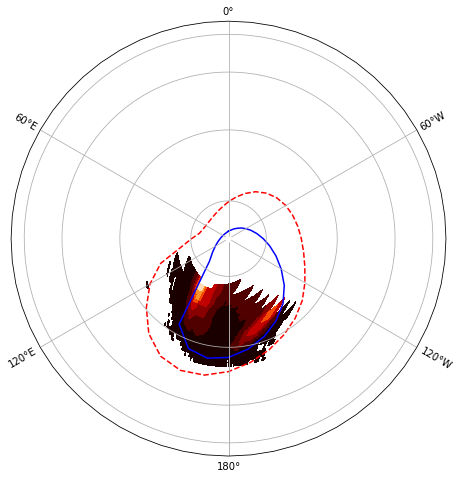

In [18]:
h3p_div2 = fits.open(plots_dir+'h3p_div_x150_y187_t.fits', ignore_missing_end=True)[0].data

main_oval = pd.read_csv('grodent_main_ovals.dat', sep='\s+', header=None)
iospot = pd.read_csv('grodent_iospot.dat', sep='\s+', header=None)

main_oval_lat = main_oval[1].to_numpy()
main_oval_long = main_oval[0].to_numpy()
# main_oval_latt = main_oval[2].to_numpy()

io_lat = iospot[1].to_numpy()
io_long = iospot[0].to_numpy()

lon = np.linspace(0, 360, 3601)
lat = np.linspace(-90, 90, 1801)

data_crs = ccrs.PlateCarree()

# lon2d, lat2d = np.meshgrid(lon, lat)

# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

# fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

# fig.add_subplot(211)

plt.figure(figsize=(15, 8))
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
# ax = plt.axes(projection=ccrs.PlateCarree(180))
ax = plt.axes(projection=ccrs.Orthographic(180, 90))
ax.set_global()
# ax.contourf(lon, lat, h3p_div2, transform=data_crs, cmap='gist_heat')
ax.plot(main_oval_long, main_oval_lat, transform=data_crs, c='b', ls='-')
ax.plot(io_long, io_lat, transform=data_crs, c='r', ls='--')
# ax.contourf(lon, lat, h3p_div, cmap='gist_heat')
# ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = True
gl.right_labels = True

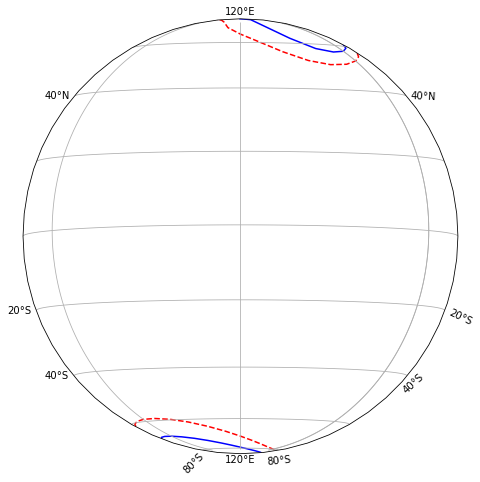

In [15]:
h3p_div2 = fits.open(plots_dir+'h3p_div_x150_y187_t.fits', ignore_missing_end=True)[0].data

main_oval = pd.read_csv('grodent_main_ovals.dat', sep='\s+', header=None)
iospot = pd.read_csv('grodent_iospot.dat', sep='\s+', header=None)

main_oval_lat = main_oval[1].to_numpy()
main_oval_long = main_oval[0].to_numpy()
main_oval_latt = main_oval[2].to_numpy()

io_lat = iospot[1].to_numpy()
io_long = iospot[0].to_numpy()
io_latt = iospot[2].to_numpy()

lon = np.linspace(0, 360, 3601)
lat = np.linspace(-90, 90, 1801)

data_crs = ccrs.PlateCarree()

# lon2d, lat2d = np.meshgrid(lon, lat)

# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

# fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

# fig.add_subplot(211)

plt.figure(figsize=(15, 8))
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
# ax = plt.axes(projection=ccrs.PlateCarree(180))
ax = plt.axes(projection=ccrs.Orthographic(120, -3))
ax.set_global()
# ax.contourf(lon, lat, h3p_div2, transform=data_crs, cmap='gist_heat')
ax.plot(main_oval_long, main_oval_lat, transform=data_crs, c='b', ls='-')
ax.plot(io_long, io_lat, transform=data_crs, c='r', ls='--')
ax.plot(main_oval_long, main_oval_latt, transform=data_crs, c='b', ls='-')
ax.plot(io_long, io_latt, transform=data_crs, c='r', ls='--')
# ax.contourf(lon, lat, h3p_div, cmap='gist_heat')
# ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = True
gl.right_labels = True

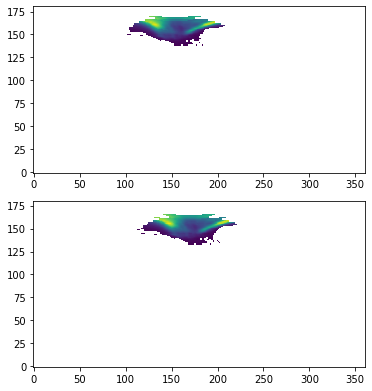

In [104]:
h3p_div_rs = np.array(Image.fromarray(h3p_div2).resize(size=(361, 181), resample=0))

h3p_div_rs_roll = np.roll(h3p_div_rs, 15,axis=1)
h3p_div_rs_roll = np.roll(h3p_div_rs_roll, -5, axis=0)

fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

fig.add_subplot(311)
# plt.plot(grid_z1[1600])
# plt.xlim(100,200)
# plt.ylim(150,170)
plt.imshow(h3p_div_rs, origin='lower')

fig.add_subplot(312)
# plt.plot(grid_z1[1600])
# plt.xlim(100,200)
# plt.ylim(150,170)
plt.imshow(h3p_div_rs_roll, origin='lower')

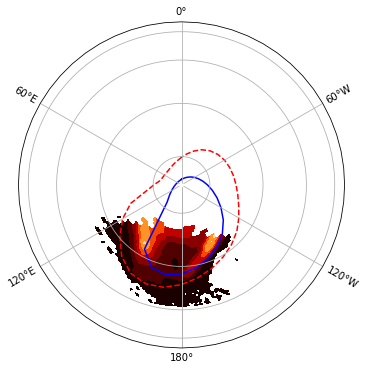

In [105]:
main_oval = pd.read_csv('grodent_main_ovals.dat', sep='\s+', header=None)
iospot = pd.read_csv('grodent_iospot.dat', sep='\s+', header=None)

main_oval_lat = main_oval[1].to_numpy()
main_oval_long = main_oval[0].to_numpy()
# main_oval_latt = main_oval[2].to_numpy()

io_lat = iospot[1].to_numpy()
io_long = iospot[0].to_numpy()

lon = np.linspace(0, 360, 361)
lat = np.linspace(-90, 90, 181)

data_crs = ccrs.PlateCarree()

# lon2d, lat2d = np.meshgrid(lon, lat)

# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

plt.figure(figsize=(14, 6))
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
# ax = plt.axes(projection=ccrs.PlateCarree(180))
ax = plt.axes(projection=ccrs.Orthographic(180, 90))
ax.set_global()
ax.contourf(lon, lat, h3p_div_rs_roll, transform=data_crs, cmap='gist_heat')
ax.plot(main_oval_long, main_oval_lat, transform=data_crs, c='b', ls='-')
ax.plot(io_long, io_lat, transform=data_crs, c='r', ls='--')
# ax.contourf(lon, lat, h3p_div, cmap='gist_heat')
# ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = True
gl.right_labels = True

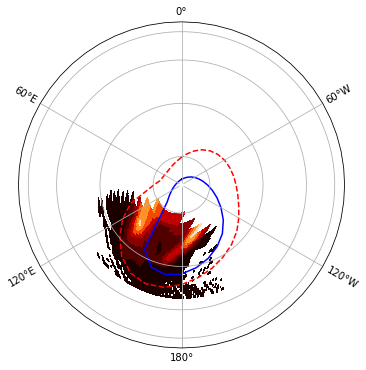

In [24]:
main_oval = pd.read_csv('grodent_main_ovals.dat', sep='\s+', header=None)
iospot = pd.read_csv('grodent_iospot.dat', sep='\s+', header=None)

main_oval_lat = main_oval[1].to_numpy()
main_oval_long = main_oval[0].to_numpy()
# main_oval_latt = main_oval[2].to_numpy()

io_lat = iospot[1].to_numpy()
io_long = iospot[0].to_numpy()

lon = np.linspace(0, 360, 3601)
lat = np.linspace(-90, 90, 1801)

data_crs = ccrs.PlateCarree()

# lon2d, lat2d = np.meshgrid(lon, lat)

# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

plt.figure(figsize=(14, 6))
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
# ax = plt.axes(projection=ccrs.PlateCarree(180))
ax = plt.axes(projection=ccrs.Orthographic(180, 90))
ax.set_global()
ax.contourf(lon, lat, h3p_div2, transform=data_crs, cmap='gist_heat')
ax.plot(main_oval_long, main_oval_lat, transform=data_crs, c='b', ls='-')
ax.plot(io_long, io_lat, transform=data_crs, c='r', ls='--')
# ax.contourf(lon, lat, h3p_div, cmap='gist_heat')
# ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = True
gl.right_labels = True

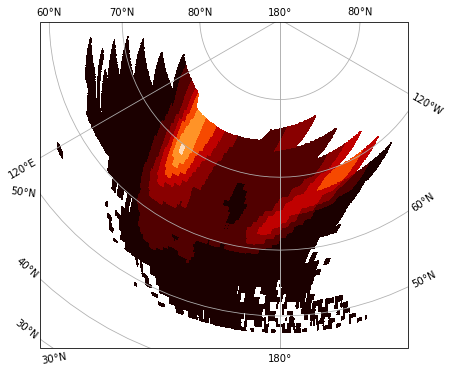

In [22]:
lon = np.linspace(0, 360, 3601)
lat = np.linspace(-90, 90, 1801)

data_crs = ccrs.PlateCarree()

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.Orthographic(180, 90))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(lon, lat, h3p_div, transform=data_crs, cmap='gist_heat')
# plt.pcolormesh(lon, lat, h3p_div, cmap='gist_heat')
# a.gridlines(draw_labels=True)
# ax.coastlines()
gl = ax.gridlines(draw_labels=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Count')

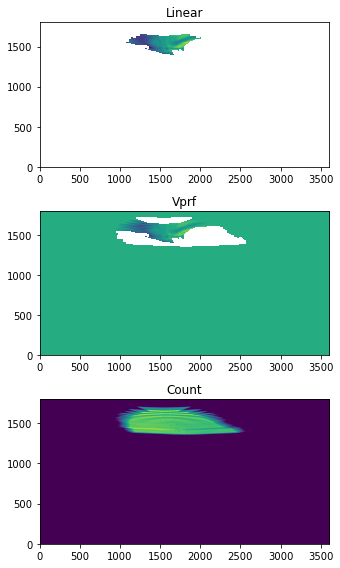

In [267]:
cml = jup_cml[20]
seangle=-3.098 # needed
r = ang_diam/(0.1)/2
posangle=0

h3p_vprf2 = np.delete(h3p_vprf, np.s_[:16], axis=0)

h3p_vfull = np.zeros((1801, 3601))
h3p_vcount = np.zeros((1801, 3601))

for j in range(22):
    
    cml = jup_cml[j]
    
    for i in range(301):
        x = i - 150
        y = 186 - j*2
        
#         if j == 3 or j == 4:
        
        grid_y, grid_x = np.mgrid[-90:90:1801j, 0:360:3601j]

        latlong = slit_to_lat_long(x,y,r,seangle,posangle,cml)

        points = np.stack((latlong[1][0:4], latlong[0][0:4]), axis=1)

        if np.count_nonzero(points) == 8:


            values = (points[:,0]*0 + 1.)*h3p_vprf2[j][i]

            grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)

            h3p_vfull += grid_z1*1

            grid_z1[np.nonzero(grid_z1)] = 1

            h3p_vcount += grid_z1*1
            
            
fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

fig.add_subplot(311)
plt.imshow(h3p_vfull/h3p_vcount, origin='lower')
# plt.xlim(1000,2000)
# plt.ylim(1500,1700)
plt.title('Linear')

fig.add_subplot(312)
plt.imshow(h3p_vfull, origin='lower')
# plt.xlim(1000,2000)
# plt.ylim(1500,1700)
plt.title('Vprf')

fig.add_subplot(313)
# plt.plot(grid_z1[1600])
plt.imshow(h3p_vcount, origin='lower')
# plt.xlim(1000,2000)
# plt.ylim(1500,1700)
plt.title('Count')

In [268]:
hdu1 = fits.PrimaryHDU(h3p_vfull)
hdu1.writeto('h3p_vprf_full.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h3p_vcount)
hdu2.writeto('h3p_vprf_count.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h3p_vfull/h3p_vcount)
hdu3.writeto('h3p_vprf_div.fits', overwrite=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


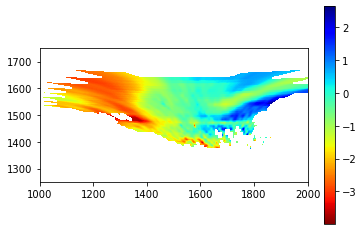

In [269]:
h3p_vprf_div = fits.open('h3p_vprf_div.fits', ignore_missing_end=True)[0].data

plt.imshow(h3p_vprf_div, origin='lower', cmap='jet_r')
plt.xlim(1000,2000)
plt.ylim(1250,1750)
plt.colorbar()

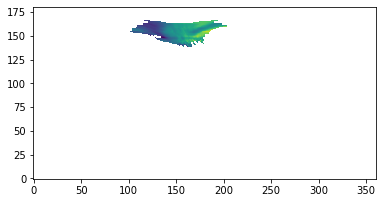

In [270]:
h3p_vprf_div_rs = np.array(Image.fromarray(h3p_vprf_div).resize(size=(361, 181), resample=0))

fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

fig.add_subplot(313)
# plt.plot(grid_z1[1600])
# plt.xlim(100,200)
# plt.ylim(150,170)
plt.imshow(h3p_vprf_div_rs, origin='lower')

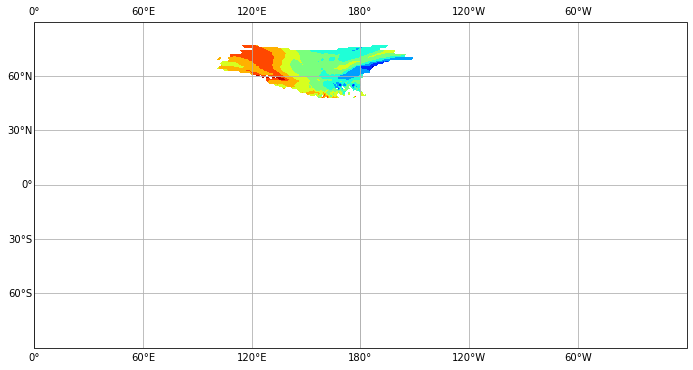

In [272]:
lon = np.linspace(0, 360, 361)
lat = np.linspace(-90, 90, 181)

data_crs = ccrs.PlateCarree()

# lon2d, lat2d = np.meshgrid(lon, lat)

# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

plt.figure(figsize=(14, 6))
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax = plt.axes(projection=ccrs.PlateCarree(180))
# ax = plt.axes(projection=ccrs.Orthographic(180, 90))
ax.set_global()
ax.contourf(lon, lat, h3p_vprf_div_rs, transform=data_crs, cmap='jet_r')
# ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = True
gl.right_labels = True

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Count')

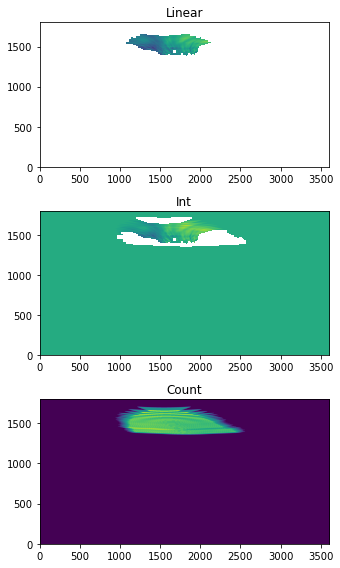

In [273]:
cml = jup_cml[20]
seangle=-3.098 # needed
r = ang_diam/(0.1)/2
posangle=0

h2_vprf2 = np.delete(h2_vprf, np.s_[:16], axis=0)

h2_full = np.zeros((1801, 3601))
h2_count = np.zeros((1801, 3601))

for j in range(22):
    
    cml = jup_cml[j]
    
    for i in range(301):
        x = i - 150
        y = 186 - j*2
        
#         if j == 3 or j == 4:
        
        grid_y, grid_x = np.mgrid[-90:90:1801j, 0:360:3601j]

        latlong = slit_to_lat_long(x,y,r,seangle,posangle,cml)

            #print(slit_to_lat_long(x,y,r,seangle,posangle,cml)[1][0:4])

        points = np.stack((latlong[1][0:4], latlong[0][0:4]), axis=1)

        if np.count_nonzero(points) == 8:

#                 print(points)

            values = (points[:,0]*0 + 1.)*h2_vprf2[j][i]

            grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)

            h2_full += grid_z1*1

            grid_z1[np.nonzero(grid_z1)] = 1
            h2_count += grid_z1*1
#                 print(points)
#                 print(values)
            
            
fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

fig.add_subplot(311)
plt.imshow(h2_full/h2_count, origin='lower')
# plt.xlim(1000,2000)
# plt.ylim(1500,1700)
plt.title('Linear')

fig.add_subplot(312)
plt.imshow(h2_full, origin='lower')
# plt.xlim(1000,2000)
# plt.ylim(1500,1700)
plt.title('Int')

fig.add_subplot(313)
# plt.plot(grid_z1[1600])
plt.imshow(h2_count, origin='lower')
# plt.xlim(1000,2000)
# plt.ylim(1500,1700)
plt.title('Count')

In [275]:
hdu1 = fits.PrimaryHDU(h2_full)
hdu1.writeto('h2_vprf_full.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h2_count)
hdu2.writeto('h2_vprf_count.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h2_full/h2_count)
hdu3.writeto('h2_vprf_div.fits', overwrite=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


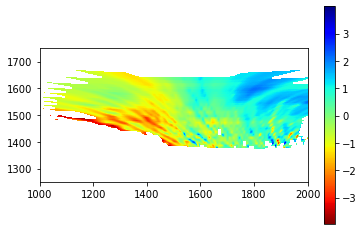

In [276]:
h2_vprf_div = fits.open('h2_vprf_div.fits', ignore_missing_end=True)[0].data

plt.imshow(h2_vprf_div, origin='lower', cmap='jet_r')
plt.xlim(1000,2000)
plt.ylim(1250,1750)
plt.colorbar()

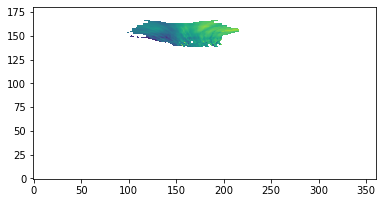

In [277]:
h2_vprf_div_rs = np.array(Image.fromarray(h2_vprf_div).resize(size=(361, 181), resample=0))

fig = plt.figure(figsize=(15,8), tight_layout=True, facecolor='white')

fig.add_subplot(313)
# plt.plot(grid_z1[1600])
# plt.xlim(100,200)
# plt.ylim(150,170)
plt.imshow(h2_vprf_div_rs, origin='lower')

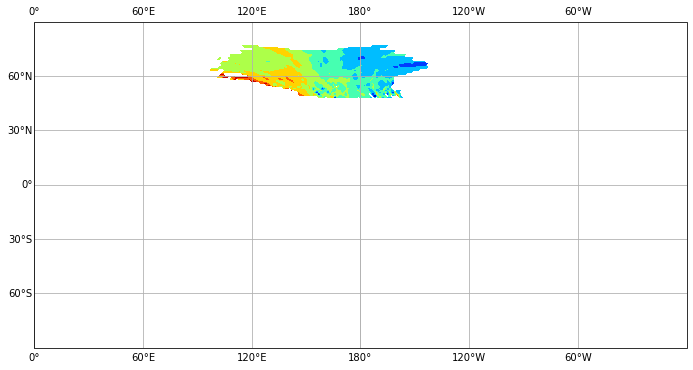

In [278]:
lon = np.linspace(0, 360, 361)
lat = np.linspace(-90, 90, 181)

data_crs = ccrs.PlateCarree()

# lon2d, lat2d = np.meshgrid(lon, lat)

# data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

plt.figure(figsize=(14, 6))
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax = plt.axes(projection=ccrs.PlateCarree(180))
# ax = plt.axes(projection=ccrs.Orthographic(180, 90))
ax.set_global()
ax.contourf(lon, lat, h2_vprf_div_rs, transform=data_crs, cmap='jet_r')
# ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = True
gl.right_labels = True

[ 95.87640123  55.59174208  19.52937836 179.03750604]
[ 21.03855337  53.37869623 103.07927838  58.97435324]


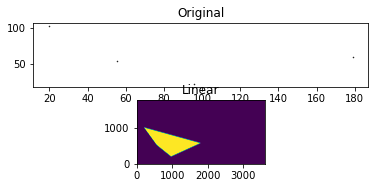

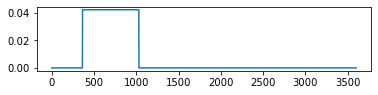

In [30]:
grid_y, grid_x = np.mgrid[0:180:1801j, 0:360:3601j] #from 0 to 360/180 in 0.1 steps

rng = np.random.default_rng()
points = rng.random((4, 2))*180. # four random latitute and four longitude positions for the four corners

values = (points[:,0]*0 + 1.)*h3p_int[20][100] # set the brightness to 1 for all four corners

# grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear') # NaNs for where the pixel isn't, and numbers where it is
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0) # 0s for where the pixel isn't, and numbers where it is

print(points[:,0])
print(points[:,1])

plt.subplot(311)
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')


plt.subplot(312)
plt.imshow(grid_z1, origin='lower')
plt.title('Linear')
plt.show()

plt.subplot(313)
plt.plot(grid_z1[800])

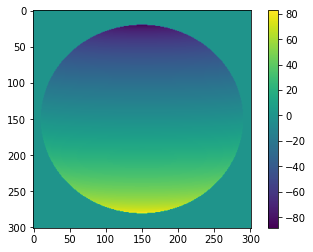

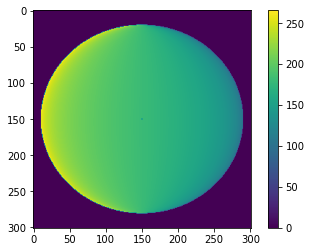

In [266]:
cml = jup_cml[20]
seangle=-3.098 # needed
r = 140#ang_diam/(0.1)/2
posangle=0

lat = []
long = []

for j in range(-150,151):
    
    latarr = np.zeros(301)
    longarr = np.zeros(301)
    
    for i in range(-150,151):
        latarr[i+150] = nirspec_calc_lat_long(i,j,r,seangle,posangle,cml)[0][4]
        longarr[i+150] = nirspec_calc_lat_long(i,j,r,seangle,posangle,cml)[1][4]
    
    lat.append(latarr)
    long.append(longarr)

lat = np.degrees(np.array(lat))
long = np.degrees(np.array(long))

plt.figure()
plt.imshow(lat)
plt.colorbar()

plt.figure()
plt.imshow(long)
plt.colorbar()

<Figure size 432x288 with 0 Axes>

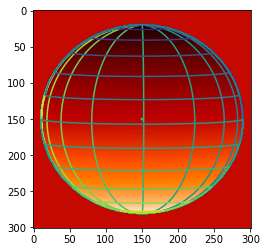

<Figure size 432x288 with 0 Axes>

In [36]:
latd = np.degrees(lat)
longd = np.degrees(long)

plt.figure()
plt.imshow(np.degrees(lat), cmap='gist_heat')
plt.contour(longd, 13)
plt.contour(latd, 13)

plt.figure()
# plt.imshow(np.degrees(long))

